## Пример кластеризации на реальных данных
В этом примере мы рассмотрим применение метода K-means к реальным данным. Согласно описанию, объекты — люди возраста 18 лет. Каждый объект обладает тремя атрибутами: Пол (Gender), Рост (Height) и Вес (Weight). Для начала подключим необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing

Импортируем датасет в датафрейм и проверим, все ли корректно импортировалось. 

<b>Примечание:</b> Изначально рост был указан в дюймах, а вес -- в фунтах. Для удобства восприятия значения были переведены в сантиметры и килограммы, соответственно.

In [2]:
df = pd.read_csv("height-weight_metric.csv", sep=";", decimal='.', index_col='id')
df.head()

,Gender,Height,Weight
id,,,
1,Male,187.571423,109.720985
2,Male,174.706036,73.622732
3,Male,188.239668,96.497550
4,Male,182.196685,99.809504
5,Male,177.499761,93.598619


Поскольку каждый объект имеет всего три признака, вполне возможно построить график в 3d. Для этого сначала сделаем признак <code>Gender</code> числовым (женщинам поставим в соответствие 0, мужчинам — 1).

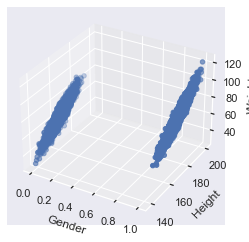

In [3]:
### 3d построение
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")
df['Gender'].replace('Female', 0, inplace = True)
df['Gender'].replace('Male', 1, inplace = True)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Gender']
y = df['Height']
z = df['Weight']

ax.set_xlabel("Gender")
ax.set_ylabel("Height")
ax.set_zlabel("Weight")
ax.scatter(x, y, z)
plt.show()

Нетрудно заметить, что объекты явно можно разделить на 2 кластера по половому признаку. Это было очевидно с самого начала, поэтому попробуем на пол пока что внимания не обращать (исключим его из предикторов).

<Axes: xlabel='Height', ylabel='Weight'>

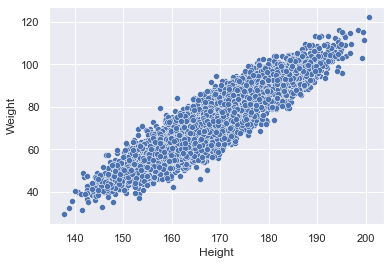

In [4]:
df_no_gender = df.drop(columns = 'Gender')
sns.scatterplot(data = df_no_gender, x = "Height", y = "Weight")

Выбросов не видно. Данные имеют разные единицы измерения, стандартизуем их. Используем линейную нормировку (MinMaxScaler).

<Axes: xlabel='Height', ylabel='Weight'>

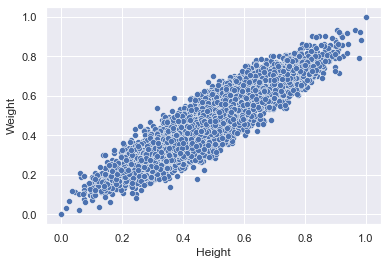

In [5]:
stand = preprocessing.MinMaxScaler()
X = stand.fit_transform(df_no_gender)
X = pd.DataFrame(X, index = df_no_gender.index, columns = df_no_gender.columns)
sns.scatterplot(data = X, x = "Height", y = "Weight")

Теперь нужно определиться с количеством кластеров. Построим график каменистой осыпи.

In [ ]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# Рассмотрим число кластеров с запасом
K = range(2, 31)

# Для каждого k будет построено 10 моделей, выбирается в итоге лучшая (меньшая сумма внутрикластерных расстояний, значение inertia_).
# Начальная инициализация по умолчания производится методом k-means++
dist = [KMeans(n_clusters = k, random_state = 1, n_init = 10).fit(X).inertia_ for k in tqdm_notebook(K)]
rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = K
rock_line[r'$Q_{final}(K)$'] = dist

  0%|          | 0/29 [00:00<?, ?it/s]

Text(0.5, 1.0, 'График каменистой осыпи')

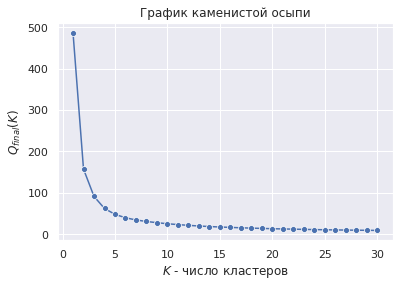

In [7]:
sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$Q_{final}(K)$", markers = True, marker = 'o').set_title('График каменистой осыпи')

Рассмотрим более детально случаи до 10 кластеров.

100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


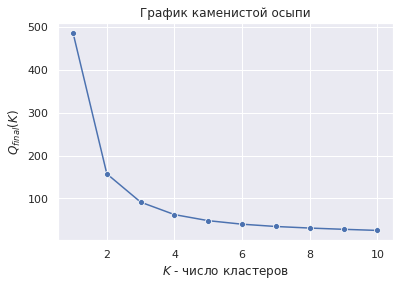

In [8]:
K = range (1, 11)

# Строим 10 моделей с разным числом кластеров. Качество кластеризации содержится в model.inertia_
dist = [KMeans(n_clusters = k, random_state = 1, n_init = 10).fit(X).inertia_ for k in tqdm(K)]
rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = K
rock_line[r'$Q_{final}(K)$'] = dist
lnplt = sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$Q_{final}(K)$", markers = True, marker = 'o').set_title('График каменистой осыпи')
lnplt = lnplt.get_figure()    
lnplt.savefig('rock_line_example_2.png', dpi=400)

Можно заметить, что график начинает быть более пологим, начиная с отметки в четыре кластера. Значит, попробуем разбить на четыре кластера.

In [9]:
#Добавим в данные графу "кластер" и посмотрим
model = KMeans(n_clusters = 4, random_state = 1, n_init=10)
model.fit(X)
df_no_gender['Cluster'] = model.labels_
df_no_gender.groupby('Cluster').mean()

,Height,Weight
Cluster,,
0,164.310241,65.892000
1,172.597402,80.320492
2,155.295273,53.728763
3,182.134194,92.990650


Что же у нас получилось?


*   0 — 164 см, 66 кг — люди невысокого роста (в эту категорию, скорее всего, в основном отнесены женщины; впрочем, сюда могут быть отнесены и невысокие мужчины);
*   1 — 173 см, 80 кг — скорее всего мужчины среднего роста и относительно крупные женщины;
*   2 — 155 см, 53 кг — в основном женщины обычной комплекции (возможно, некоторые совсем некрупные мужчины);
*   3 — 182 см, 93 кг — скорее всего крупные мужчины, не исключены и совсем крупные женщины.

Построим график.

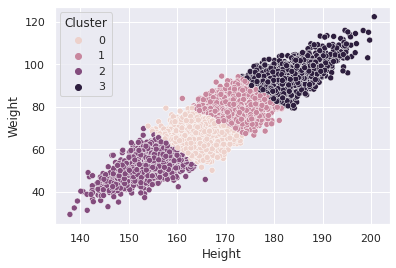

In [10]:
sns.scatterplot(data = df_no_gender, x = "Height", y = "Weight", hue = 'Cluster')

Проверим наши предположения, а именно включим признак "Пол"

In [11]:
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0.184518,164.310241,65.892000
1,0.807783,172.597402,80.320492
2,0.018972,155.295273,53.728763
3,0.991085,182.134194,92.990650


Мы оказались правы, действительно, кластер 0 состоит из порядка 20 процентов некрупных мужчин, в кластере 1 -- порядка 20 процентов относительно крупных женщин. Кластеры 2 и 3 практически моногендерны.

Рассмотрим случай с тремя кластерами.

In [12]:
model = KMeans(n_clusters = 3, random_state = 1, n_init=10)
model.fit(X)
df_no_gender['Cluster'] = model.labels_
df_no_gender.groupby('Cluster').mean()

,Height,Weight
Cluster,,
0,168.867442,73.762111
1,179.972098,90.388047
2,157.868897,57.008537


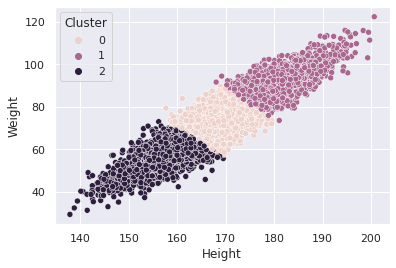

In [13]:
sns.scatterplot(data=df_no_gender, x="Height", y="Weight", hue = 'Cluster')

В таком случае имеем:

*   0 — стандартные люди. Средний рост, средний вес;
*   1 — высокие, крупные люди;
*   2 — миниатюрные люди.

Добавим в процесс кластеризации пол. Поскольку пол обозначается числами 0 или 1, то в результате линейной нормировки эти значения сохранятся, поэтому просто добавим к нашему нормированному набору данных X столбец <code>Gender</code>.

In [14]:
X['Gender'] = df['Gender']
X.head()

,Height,Weight,Gender
id,,,
1,0.791728,0.863139,1
2,0.586958,0.475476,1
3,0.802364,0.721131,1
4,0.706182,0.756699,1
5,0.631424,0.689999,1


Проведем аналогичные процедуры, что и в предыдущем случае.

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Text(0.5, 1.0, 'График каменистой осыпи')

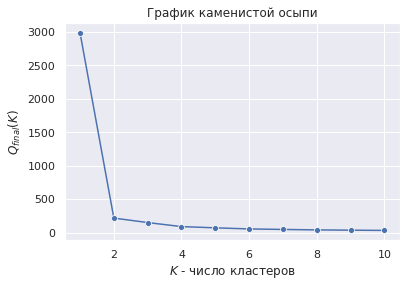

In [15]:
K = range (1, 11)

# Строим 10 моделей с разным числом кластеров. Качество кластеризации содержится в model.inertia_
dist = [KMeans(n_clusters = k, random_state = 1, n_init = 10).fit(X).inertia_ for k in tqdm(K)]
rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = K
rock_line[r'$Q_{final}(K)$'] = dist
sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$Q_{final}(K)$", markers = True, marker = 'o').set_title('График каменистой осыпи')

Очевидно разделение на два кластера, хотя можно заподозрить и четыре.

In [16]:
model = KMeans(n_clusters = 2, random_state = 1, n_init=10)
model.fit(X)
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0,161.820285,61.625051
1,1,175.326919,84.831057


Четкое разделение на женщин и мужчин.

А если попробовать три кластера?

In [17]:
model = KMeans(n_clusters = 3, random_state = 1, n_init=10)
model.fit(X)
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,1,180.922621,91.504462
1,0,161.820285,61.625051
2,1,169.595288,77.995546


Мужчины разделились на два кластера: пониже и повыше.

А если все же четыре?

In [18]:
model = KMeans(n_clusters = 4, random_state = 1, n_init=10)
model.fit(X)
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0,167.330037,68.289695
1,1,169.666944,78.071174
2,0,156.619011,55.333544
3,1,180.986893,91.590941


Теперь явно девушки разбились на два кластера: совсем миниатюрные и средние. Мужчины почти не изменились.

 С учетом пола график кластеризации будет выглядеть следующим образом.

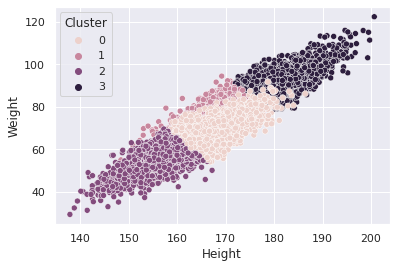

In [19]:
sns.scatterplot(data = df, x = "Height", y = "Weight", hue = 'Cluster')